In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
from discrete_basics import *
from discrete_plot import *
from discrete_sim import *
from scipy.integrate import solve_ivp
from cycler import cycler

plt.rcParams['axes.prop_cycle']=cycler('color',['#1f77b4', '#ff7f0e', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])

location = "orientation/"
try:
    os.makedirs(location)
except(FileExistsError):
    pass

# Fig.14

In [33]:
results = []
tol = 0.1

a,b,c,d = -10, 2, 15, -5
solutions = minima(a,b,c,d)
resolution = 100
dx = 1.0

dataloc = location+"npz_a{}_b{}_c{}_d{}/".format(a,b,c,d)
try:
    os.makedirs(dataloc)
except(FileExistsError):
    pass
results = []

for method in [(mesh_tri, rhs_tri,3),(mesh_reg, rhs_reg,4),(mesh_hex, rhs_hex,6),]:
    res, xv, yv = method[0](resolution)
    for coup in [2,4,6,8,10]:
        diff = coup*dx**2
        for i,j in [(0,1),(0,2),(1,2)]:
            for phi in np.arange(0,90.5,0.5):
                z = inistripe(xv,yv,resolution,phi,i,j)
                data = []
                print("{}_front u_{}{}, D = {}, phi = {}".format(method[0].__name__[-3:],i,j,diff,phi), end="\r")
                try:
                    with np.load(dataloc+method[0].__name__[-3:]+"_D{}_dx{}_r{}_phi{}_{}_t1.npz".format(diff,dx,resolution,phi,i+j)) as temp:
                        z1 = temp['arr_0'].flatten()
                except(FileNotFoundError):
                    z1 = z.flatten()
                    timeplus=0
                    for tlimit in [(0.1,0.001),(1,0.01)]:
                        tstep = tlimit[1]
                        t = 0
                        while (t*tstep+timeplus)<tlimit[0]:
                            try:
                                reso = solve_ivp(method[1],[0,tstep],z1,'LSODA',args=((a,b,c,d,diff,dx,res),))
                                z1 = reso.y[:,-1]
                                t = t+1
                            except(MemoryError):
                                fig, ax = plt.subplots(1,1,figsize = (1,1))
                                plt.close()
                        timeplus = timeplus+t*tstep
                    np.savez_compressed(dataloc+method[0].__name__[-3:]+"_D{}_dx{}_r{}_phi{}_{}_t1".format(diff,dx,resolution,phi,i+j),z1)

                N_1 = len(z1[np.abs(z1-solutions[i])<tol])
                N_2 = len(z1[np.abs(z1-solutions[j])<tol])
                mask = np.array(np.abs(z1-solutions[i])>tol) * np.array(np.abs(z1-solutions[j])>tol)
                error, distance = vecfitter(xv.flatten()[mask],yv.flatten()[mask],phi)
                
                results.append([method[2],coup,i+j,phi,N_1,N_2,np.sum(z1-z.flatten()),distance, error])
#                f = open(dataloc+method[0].__name__[-3:]+"_D{}_dx{}_r{}_angular.txt".format(diff,dx,resolution),'a')
 #               f.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(i+j,phi,coup,N_1,N_2,N_3,np.sum(z1-z.flatten()),error,deviation,calcstep(deviation,phi,resolution)))
  #              f.close()

results = np.asarray(results)
filename = "{}_{}_{}_c{:.2f}_d{}.txt".format(resolution,a,b,c,d)
np.savetxt(location+filename, results)

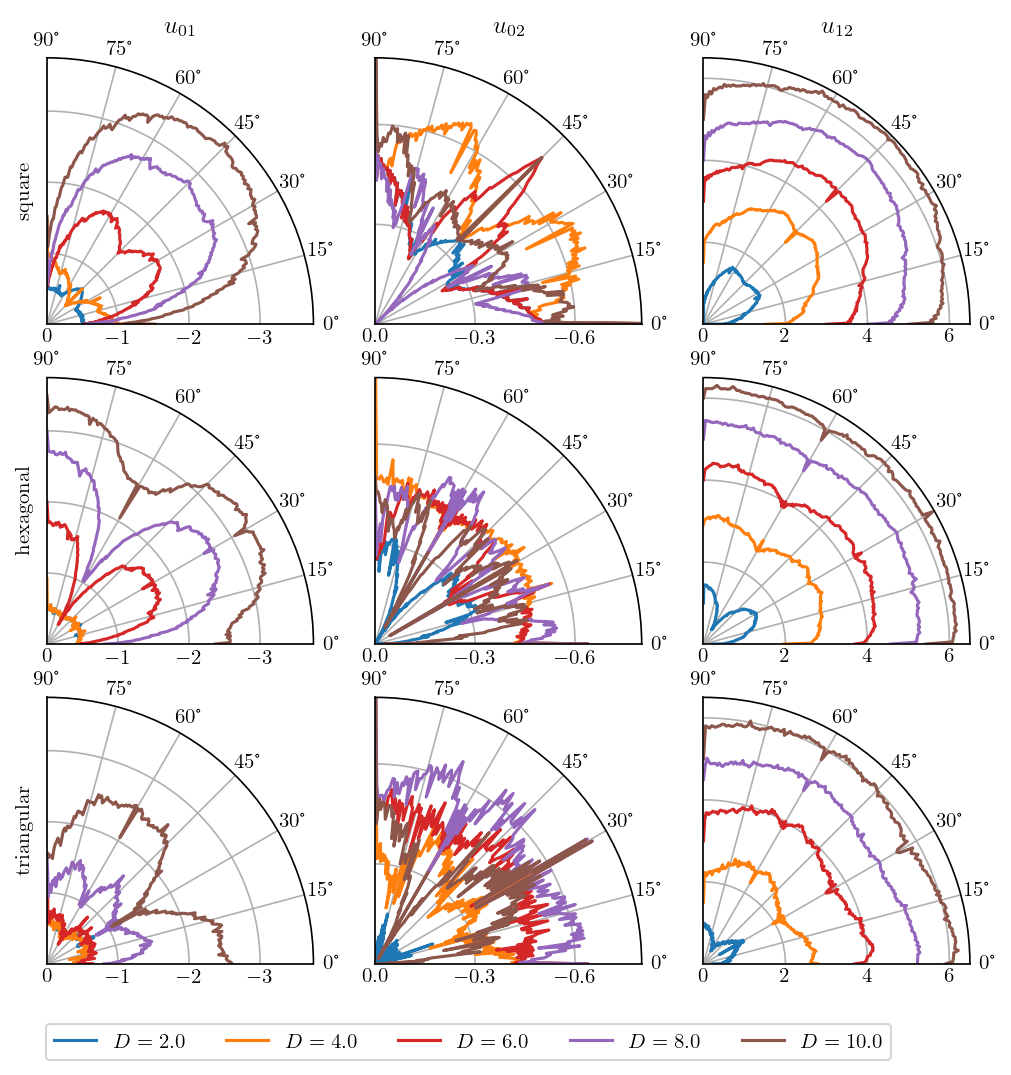

In [2]:
mpl.rcParams['backend'] = 'pdf'
mpl.rc('font',**{'family':'serif'})
mpl.rcParams['mathtext.fontset'] = 'cm'
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amssymb,amsmath,wasysym}')

a,b,c,d = -10, 2, 15, -5
resolution = 100
dx = 1.0

filename = "{}_{}_{}_c{:.2f}_d{}.txt".format(resolution,a,b,c,d)
            #        0       1   2   3   4   5        6                  7         8
#results.append([method[2],coup,i+j,phi,N_1,N_2,np.sum(z1-z.flatten()),distance, error])
data = np.loadtxt(location+filename)
data[:,3] = np.deg2rad(data[:,3])

fig, axs = plt.subplots(3, 3,figsize = (8,8),subplot_kw={'projection': 'polar'},dpi=150)
solutions = minima(a,b,c,d)
for method in [('reg', 4, 0),('hex', 6, 1),('tri', 3, 2)]:
    mask1 = data[:,0] == method[1]
    for diff in [2.0,4.0,6.0,8.0,10.0]:#,15.0]:#
        mask2 = data[:,1] == diff
        for i in range(3):
            axs[i,0].set_rticks([-4,-3,-2,-1,0])
            axs[i,0].set_rlim(0,-3.75)

            axs[i,1].set_rticks([0.0,-0.3,-0.6,-0.9])
            axs[i,1].set_rlim(0,-0.8)

            axs[i,2].set_rticks([0,2,4,6])
            axs[i,2].set_rlim(0,6.5)
            for j in range(3):
                axs[j,i].set_thetamin(0)
                axs[j,i].set_thetamax(90)
                axs[j,i].set_xticks(np.deg2rad([0,15,30,45,60,75,90]))
                axs[j,i].xaxis.set_tick_params(pad=-2)
                axs[j,i].yaxis.set_tick_params(pad=-2)
        for ini in [1,2,3]:
            mask3 = data[:,2] == ini
            data1 = data[mask1*mask2*mask3]
            axs[method[2],ini-1].plot(data1[:,3],data1[:,7],label=r'$D={}$'.format(diff))
axs[2,1].legend(loc="lower center",bbox_to_anchor=(0., -0.4, 0.7, -0), ncol=5)
axs[0,0].set_ylabel('square')
axs[1,0].set_ylabel('hexagonal')
axs[2,0].set_ylabel('triangular')

axs[0,0].set_title(r'$u_{01}$')
axs[0,1].set_title(r'$u_{02}$')
axs[0,2].set_title(r'$u_{12}$')
fig.savefig("14_dx{}_r{}_angular_d.pdf".format(dx,resolution))
plt.show()